## 1. Download the ~70GB 3D LIDAR Object Detection data from the KITTI dataset

### 1.1 First I downloaded the zipped LiDAR, camera, calibration, and label data from the KITTI dataset, and transferred to my google drive. For subsequent usage, I transfer and unzip the files from google drive.

In [ ]:
# !wget -O "/content/gdrive/MyDrive/KITTI_data/data_object_image_2.zip" "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip"
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_velodyne.zip
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_calib.zip
# !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip

In [ ]:
# # Transfer zipped files to google drive (unzipped files are too big)
# !cp -r data_object_velodyne.zip /content/gdrive/My\ Drive/KITTI_data/
# !cp -r data_object_calib.zip /content/gdrive/My\ Drive/KITTI_data/
# !cp -r data_object_label_2.zip /content/gdrive/My\ Drive/KITTI_data/

### 1.2 Once Downloaded, unzip from drive to colab environment.

In [2]:
# move downloaded files to my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Transfer and unzip files from Google Drive. Only transfer 1500/7481 LIDAR files due to storage constraints

In [3]:
# transfer drive files to colab and unzip them
import zipfile
import os

# List of file names
file_names = ["data_object_calib.zip", "data_object_label_2.zip", 'data_object_image_2.zip']

# Directory in Google Drive where the files are located
drive_path = "/content/gdrive/My Drive/KITTI_data/"

# Loop over each file and unzip it
for file_name in file_names:
    # Construct full file path
    file_path = os.path.join(drive_path, file_name)

    # Check if the file exists in Google Drive
    if os.path.exists(file_path):
        print(f"Unzipping {file_name} ...")

        # Unzip the file
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall("/content/")  # Extracting to the root directory of Colab
        print(f"{file_name} unzipped successfully!")
    else:
        print(f"{file_name} not found in Google Drive.")

# number of velodyne/lidar frames to extract:
n_lidar = 1500
# Source and destination paths
zip_file_path = "/content/gdrive/My Drive/KITTI_data/data_object_velodyne.zip"
extract_folder = "/content/velodyne"

# Ensure the extraction directory exists
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Get a list of all file names in the zip
    all_files = zip_ref.namelist()

    # Extract only the first 1500 files
    for file in all_files[:n_lidar]:
        zip_ref.extract(file, extract_folder)

print(f"Extracted the first {n_lidar} files to {extract_folder}")


Unzipping data_object_calib.zip ...
data_object_calib.zip unzipped successfully!
Unzipping data_object_label_2.zip ...
data_object_label_2.zip unzipped successfully!
Unzipping data_object_image_2.zip ...
data_object_image_2.zip unzipped successfully!
Extracted the first 1500 files to /content/velodyne


In [4]:
# Storage used
!df -h


Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   44G   35G  56% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.1G  849M  57% /usr/sbin/docker-init
/dev/sda1        85G   66G   20G  78% /opt/bin/.nvidia
tmpfs           6.4G  132K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive            79G   46G   33G  58% /content/gdrive


## 2. Data Exploration:

### 2.1. Visualize some LIDAR point clouds and corresponding camera images

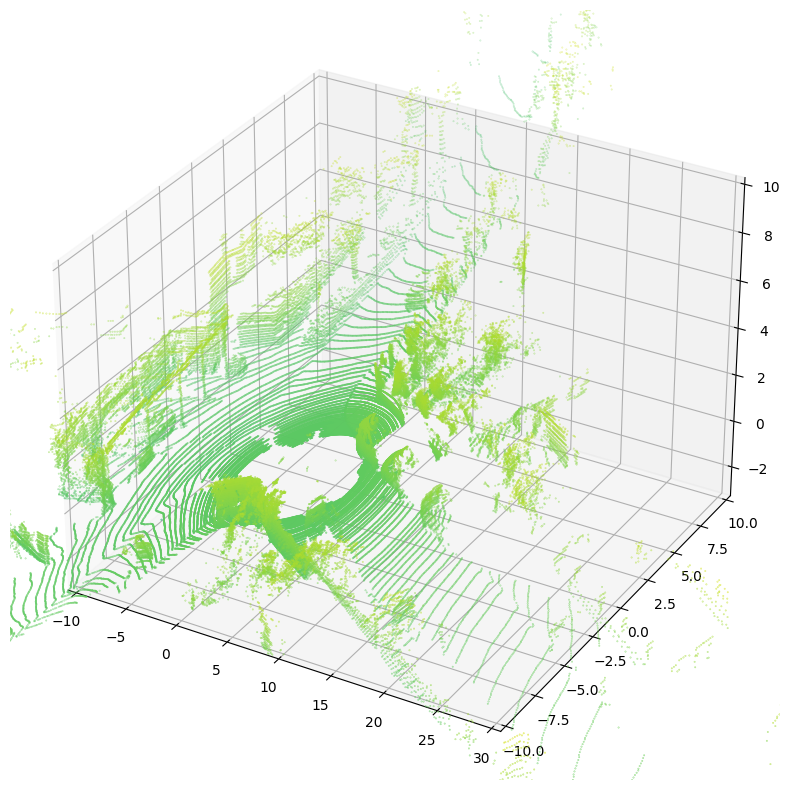

velodyne/training/velodyne/000008.bin /content/training/image_2/000008.png


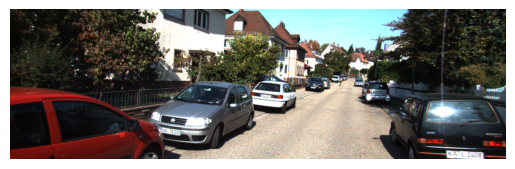

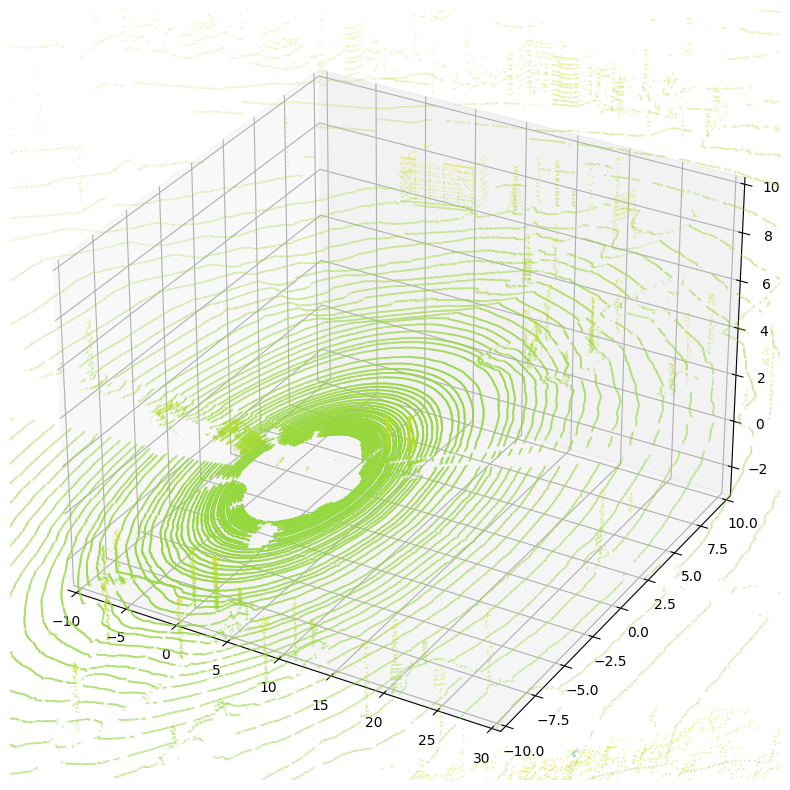

velodyne/training/velodyne/000012.bin /content/training/image_2/000012.png


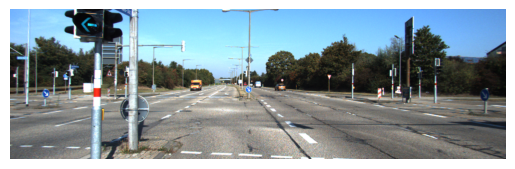

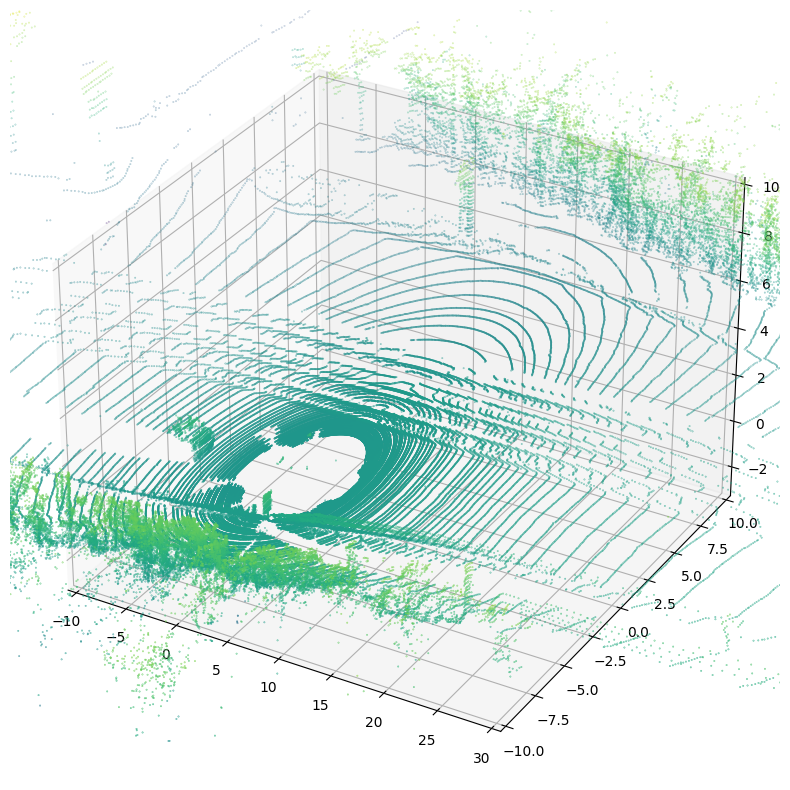

velodyne/training/velodyne/000023.bin /content/training/image_2/000023.png


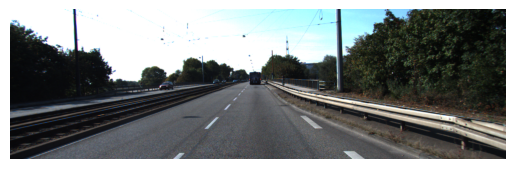

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import cv2

def load_velodyne_points(filename):
    """Load 3D point cloud from KITTI file format .bin file."""
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    # points are in the format (x, y, z, reflectance), we drop reflectance
    return points[:, :3]

def display_pointcloud(points):
    """Display a 3D point cloud."""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap='viridis', s=0.1)
    ax.set_xlim(-10, 30)
    ax.set_ylim(-10, 10)
    ax.set_zlim(-3, 10)
    plt.show()


# Function to load and display an image
def display_image(image_path):
    # Load the image from file
    image = cv2.imread(image_path)

    # Convert color space from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Number of point clouds you want to visualize
n = 3
folder_path = 'velodyne/training/velodyne'
# folder_path = 'velodyne'

i = 0
for filename in sorted(os.listdir(folder_path)):
    if i >= n:
      break
    i += 1
    file_path = os.path.join(folder_path, filename)
    if file_path.endswith('.bin') and os.path.isfile(file_path):
        points = load_velodyne_points(file_path)
        display_pointcloud(points)
        image_file_path = os.path.join('/content/training/image_2', filename[:7]+'png')
        print(file_path, image_file_path)
        display_image(image_file_path)


### 2.3 Load calibration data from the first calibration file. Each entry has a specific purpose:

P0, P1, P2, P3: These are 3x4 projection matrices for the left, right, front, and back cameras respectively. They transform a 3D point in the world to a 2D pixel in the image.

R0_rect: This is the 3x3 rectifying rotation matrix. It aligns the 3D point clouds obtained from the Velodyne sensor to the road plane.

Tr_velo_to_cam: This is a 3x4 transformation matrix that maps points from the Velodyne coordinate system to the camera coordinate system.

Tr_imu_to_velo: This is a 3x4 transformation matrix that maps points from the IMU coordinate system to the Velodyne coordinate system.

In [7]:
def load_calib_file(filename):
    """Load calibration data from a KITTI calibration file."""
    data = {}
    with open(filename, 'r') as f:
        for line in f:
            line = line.rstrip()
            if ' ' in line:
                key, value = line.split(' ', 1)
                data[key] = np.array([float(x) for x in value.split()])
    return data

# Load and display the first calibration file
calib_data = load_calib_file('./training/calib/000000.txt')
for key, value in calib_data.items():
    print(key, value)

P0: [707.0493   0.     604.0814   0.       0.     707.0493 180.5066   0.
   0.       0.       1.       0.    ]
P1: [ 707.0493    0.      604.0814 -379.7842    0.      707.0493  180.5066
    0.        0.        0.        1.        0.    ]
P2: [ 7.070493e+02  0.000000e+00  6.040814e+02  4.575831e+01  0.000000e+00
  7.070493e+02  1.805066e+02 -3.454157e-01  0.000000e+00  0.000000e+00
  1.000000e+00  4.981016e-03]
P3: [ 7.070493e+02  0.000000e+00  6.040814e+02 -3.341081e+02  0.000000e+00
  7.070493e+02  1.805066e+02  2.330660e+00  0.000000e+00  0.000000e+00
  1.000000e+00  3.201153e-03]
R0_rect: [ 0.9999128   0.01009263 -0.00851193 -0.01012729  0.9999406  -0.00403767
  0.00847068  0.00412352  0.9999556 ]
Tr_velo_to_cam: [ 0.00692796 -0.9999722  -0.00275783 -0.02457729 -0.00116298  0.00274984
 -0.9999955  -0.06127237  0.9999753   0.00693114 -0.0011439  -0.3321029 ]
Tr_imu_to_velo: [ 9.999976e-01  7.553071e-04 -2.035826e-03 -8.086759e-01 -7.854027e-04
  9.998898e-01 -1.482298e-02  3.195559e-

### 2.4. Load label files, corresponding to the annotations for an object in a frame, (in this case, a "Pedestrian").

Here's a breakdown of each element in the list:

1. **Type**: Describes the type of the object. Here it's `Pedestrian`.
2. **Truncation**: A float from 0 (non-truncated) to 1 (truncated), where truncated refers to the object leaving the image boundaries.
3. **Occlusion**: An integer indicating occlusion state:
   - 0 = fully visible
   - 1 = partly occluded
   - 2 = largely occluded
   - 3 = unknown
4. **Alpha**: Observation angle of the object, ranging [-π, π].
5. **Bbox**: 2D bounding box of the object in the image, given by (left, top, right, bottom) pixel coordinates. Here, it is from `(712.40, 143.00)` to `(810.73, 307.92)`.
6. **Dimensions**: 3D object dimensions in meters: height, width, and length. Here, the dimensions are `(1.89, 0.48, 1.20)` meters.
7. **Location**: 3D object location in camera coordinates in meters: x, y, z. In this case, it's located at `(1.84, 1.47, 8.41)` meters.
8. **Rotation Y**: Rotation of the object around the Y-axis in camera coordinates, ranging [-π, π].

This label data, combined with the calibration data, allows for mapping these labeled objects in 2D image space to 3D space and vice versa. You can use this information to visualize where each labeled object is in both the image and the point cloud.

In [8]:
def load_label_file(filename):
    """Load labels from a KITTI label file."""
    labels = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            labels.append(line)
    return labels

# Load and display the first label file
label_data = load_label_file('./training/label_2/000000.txt')
for item in label_data:
    print(item)

['Pedestrian', '0.00', '0', '-0.20', '712.40', '143.00', '810.73', '307.92', '1.89', '0.48', '1.20', '1.84', '1.47', '8.41', '0.01']


## 3. Data Preprocessing


#### 3.1 Camera Data Preprocessing
Preprocessing code to load the calibration data, undistort images, and project LiDAR points onto those images:

In [9]:
import numpy as np
import cv2
import os

# Assuming you have a function to parse the KITTI calibration files
def load_kitti_calibration(calib_file):
    # Parse the calibration file
    calib = {}
    with open(calib_file, 'r') as f:
        for line in f.readlines():
            if ':' in line:
                key, value = line.split(':', 1)
                calib[key] = np.array([float(x) for x in value.split()])

    # Reshape the matrices to 3x4
    calib['P2'] = calib['P2'].reshape(3, 4)
    # Only using the second camera (P2), but you can adapt this for other cameras

    # Return the relevant matrices
    return calib['P2'], calib['Tr_velo_to_cam'].reshape(3, 4)

# Load calibration data to verify it's working
calib_file = '/content/training/calib/000000.txt' # replace with your file path
P2, Tr_velo_to_cam = load_kitti_calibration(calib_file)
print(P2)
print(Tr_velo_to_cam)

[[ 7.070493e+02  0.000000e+00  6.040814e+02  4.575831e+01]
 [ 0.000000e+00  7.070493e+02  1.805066e+02 -3.454157e-01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  4.981016e-03]]
[[ 0.00692796 -0.9999722  -0.00275783 -0.02457729]
 [-0.00116298  0.00274984 -0.9999955  -0.06127237]
 [ 0.9999753   0.00693114 -0.0011439  -0.3321029 ]]


In [10]:
def undistort_image(image, P2):
    # The camera matrix and distortion coefficients are part of P2 in KITTI
    camera_matrix = P2[:3, :3]
    dist_coeffs = np.zeros((4, 1))  # KITTI datasets are already rectified, so the distortion is negligible

    undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs)
    return undistorted_image


In [11]:
def project_lidar_to_image(lidar_points, P2, Tr_velo_to_cam, image_shape):
    # Assuming lidar_points is an Nx4 matrix where columns are x, y, z, and reflectance/intensity
    # Tr_velo_to_cam is a 3x4 matrix, and P2 is a 3x4 projection matrix

    # The LiDAR points matrix should be extended to Nx4 by adding a ones column for homogeneous coordinates
    ones_col = np.ones((lidar_points.shape[0], 1))
    lidar_points_homogeneous = np.hstack((lidar_points[:, :3], ones_col))

    # The transformation matrix should be a 4x4 matrix to include the translation as well
    # Assuming Tr_velo_to_cam is 3x4, we need to convert it to 4x4
    Tr_velo_to_cam_full = np.vstack((Tr_velo_to_cam, np.array([0, 0, 0, 1])))

    # Convert LiDAR points from LiDAR coordinates to camera coordinates
    lidar_points_cam = np.dot(Tr_velo_to_cam_full, lidar_points_homogeneous.T)

    # Project the points into the image plane using the camera matrix
    # P2 is a 3x4 matrix, lidar_points_cam is now a 4xN matrix, so dot product is valid
    points_2d_homogeneous = np.dot(P2, lidar_points_cam)

    # Normalize the points by the last (homogeneous) coordinate to convert to 2D
    points_2d = points_2d_homogeneous[:2, :] / points_2d_homogeneous[2, :]

    # Transpose to make it Nx2 for easier handling
    points_2d = points_2d.T

    # Assuming image_shape is in (height, width), we extract the dimensions
    image_height, image_width = image_shape

    # Filter points that are outside the image
    valid_indices = (points_2d[:, 0] >= 0) & (points_2d[:, 0] < image_width) & \
                    (points_2d[:, 1] >= 0) & (points_2d[:, 1] < image_height)

    # Extract the valid points using the boolean indexing
    projected_points = points_2d[valid_indices]
    lidar_points_valid = lidar_points[valid_indices]

    return projected_points, lidar_points_valid


Visualize LiDAR point clouds projected onto camera images

Image shape is: (370, 1224)
velodyne/training/velodyne/000008.bin /content/training/image_2/000008.png


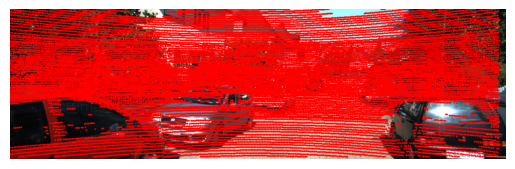

velodyne/training/velodyne/000012.bin /content/training/image_2/000012.png


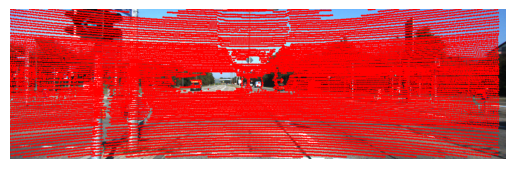

velodyne/training/velodyne/000023.bin /content/training/image_2/000023.png


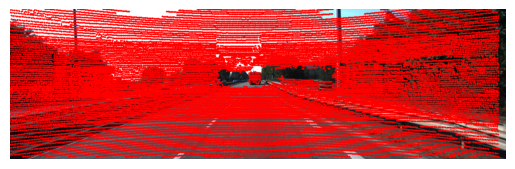

In [12]:
# Function to load and display an image with LiDAR points overlaid
def visualize_lidar_on_image(image_file, lidar_file, P2, Tr_velo_to_cam, image_shape):
    # Load the image file
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Load LiDAR points (replace this with the actual code to load your LiDAR data)
    lidar_points = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)

    # Set parameters for the projection
    max_distance = 100  # example value, you may need to adjust this
    min_distance = 0    # example value, you may need to adjust this
    image_width, image_height = image_shape

    # Project LiDAR points to the image plane
    projected_points, _ = project_lidar_to_image(lidar_points, P2, Tr_velo_to_cam, image_shape)

    # Overlay points on the image
    for point in projected_points:
        image = cv2.circle(image, (int(point[0]), int(point[1])), 2, (255, 0, 0), -1)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Get image shape
import cv2
# Load an image
image = cv2.imread('/content/training/image_2/000000.png')
# Get image shape
image_shape = image.shape[:2]  # This will give you (height, width)
print("Image shape is:", image_shape)

# Example usage:
# Number of point clouds you want to visualize
n = 3
folder_path = 'velodyne/training/velodyne'
# folder_path = 'velodyne'

i = 0
for filename in sorted(os.listdir(folder_path)):
    if i >= n:
      break
    i += 1
    lidar_file_path = os.path.join(folder_path, filename)
    if lidar_file_path.endswith('.bin') and os.path.isfile(lidar_file_path):
        # points = load_velodyne_points(lidar_file_path)
        # display_pointcloud(points)
        image_file_path = os.path.join('/content/training/image_2', filename[:7]+'png')
        print(lidar_file_path, image_file_path)
        # display_image(image_file_path)
        visualize_lidar_on_image(image_file_path, lidar_file_path, P2, Tr_velo_to_cam, image_shape)

# image_file = '/path/to/your/image.png' # Update with the path to your KITTI image
# lidar_file = '/path/to/your/velodyne_points.bin' # Update with the path to your KITTI LiDAR point cloud

# visualize_lidar_on_image(image_file, lidar_file, P2, Tr_velo_to_cam, image_shape)

The number of unique classes in the dataset labels (important for defining final layer in our model):

In [13]:
# get all labels
import os

def get_unique_classes_from_labels(label_dir):
    """Extract unique classes from all label files in a directory."""
    all_classes = set()

    # Iterate through all label files in the directory
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            labels = load_label_file(os.path.join(label_dir, label_file))

            # Extract class names and add them to the set
            for label in labels:
                all_classes.add(label[0])

    return list(all_classes)

# Extract unique classes from the label directory
unique_classes = get_unique_classes_from_labels('./training/label_2/')
num_classes = len(unique_classes)

print(f"Number of unique classes: {num_classes}")
print(f"Unique classes: {unique_classes}")

Number of unique classes: 9
Unique classes: ['DontCare', 'Pedestrian', 'Tram', 'Cyclist', 'Car', 'Person_sitting', 'Truck', 'Misc', 'Van']


See distribution in the number of points in an n=500 sample of total point clouds (useful for hyperparameter tuning):

In [15]:
folder_path = 'velodyne/training/velodyne'
point_clouds = []
n = 100
i = 0
for filename in sorted(os.listdir(folder_path)):
    if i >= n:
        break
    i += 1
    file_path = os.path.join(folder_path, filename)
    if file_path.endswith('.bin') and os.path.isfile(file_path):
        # filename = f'./training/velodyne/{str(i).zfill(6)}.bin'
        points = load_velodyne_points(file_path)
        point_clouds.append(points)
    # display_pointcloud(points)

print(len(point_clouds))
point_counts = [len(pc) for pc in point_clouds]
average_points = np.mean(point_counts)
median_points = np.median(point_counts)
max_points = np.max(point_counts)
min_points = np.min(point_counts)
print(f"point_counts: {point_counts}")
print(f"average_points: {average_points}")
print(f"median_points: {median_points}")
print(f"max_points: {max_points}")
print(f"min_points: {min_points}")

100
point_counts: [122555, 120007, 120412, 126730, 124274, 121291, 109347, 121661, 123473, 122670, 121825, 123141, 116948, 115094, 109338, 110516, 119620, 116332, 116511, 123754, 122732, 117962, 121994, 115352, 122135, 110550, 114367, 117613, 112679, 122501, 111382, 121716, 120972, 101675, 118896, 116009, 116755, 122947, 113287, 126405, 118762, 121929, 123073, 122872, 125815, 124202, 116173, 118043, 110030, 113696, 114627, 108204, 123439, 125045, 124192, 119985, 123067, 119734, 125243, 111495, 122254, 114984, 125860, 119788, 120610, 122067, 122105, 118367, 120774, 118421, 123667, 122410, 117496, 120222, 122361, 118718, 122277, 127013, 119323, 120686, 115516, 100612, 121431, 125393, 124899, 122617, 123314, 127022, 123430, 105149, 120723, 115530, 96195, 123099, 114298, 104294, 121649, 110616, 115037, 116476]
average_points: 118697.57
median_points: 120511.0
max_points: 127022
min_points: 96195


As can be seen above, the median number of points in every pointcloud is ~120,000. This is too many to input into our model below (given GPU constraints), so we will set num_points to 10,000 initially, and randomly subsample.

## 4. Pointnet Model


In [16]:
import tensorflow as tf
import numpy as np

# Input transform net
def input_transform_net(point_cloud, num_points):
    # Input transform network (T-net)
    input_image = tf.keras.layers.Input(shape=(num_points, 3))

    # Shared MLP
    x = tf.keras.layers.Conv1D(64, 1, activation='relu')(input_image)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(128, 1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(512, 1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    # x = tf.keras.layers.MaxPooling1D(pool_size=num_points)(x)

    # Fully connected
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Output 3x3 matrix
    transform = tf.keras.layers.Dense(9, weights=[tf.zeros([256, 9]), tf.constant(np.eye(3).flatten(), dtype=np.float32)])(x)
    transform = tf.keras.layers.Reshape((3, 3))(transform)

    return tf.keras.models.Model(inputs=input_image, outputs=transform)

# PointNet architecture
def pointnet_model(num_points, num_classes):
    input_points = tf.keras.layers.Input(shape=(num_points, 3))

    # Apply input transform
    transform = input_transform_net(input_points, num_points)
    transformed_output = transform(input_points)
    x = tf.keras.layers.Lambda(lambda inputs: tf.matmul(inputs[0], inputs[1]))([input_points, transformed_output])
    # x = tf.keras.layers.Dot(axes=2)([input_points, transform])

    # Shared MLP
    x = tf.keras.layers.Conv1D(64, 1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(64, 1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(128, 1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(512, 1, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Global feature
    x = tf.keras.layers.GlobalMaxPooling1D()(x)
    # x = tf.keras.layers.MaxPooling1D(pool_size=num_points)(x)
    x = tf.keras.layers.Flatten()(x)

    # Fully connected layers
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Classification layer
    output = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)


    return tf.keras.models.Model(inputs=input_points, outputs=output)

# CNN branch for camera data
def create_cnn_branch(image_shape):
    image_input = tf.keras.layers.Input(shape=image_shape)

    # Example CNN architecture
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(image_input)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)

    return tf.keras.models.Model(inputs=image_input, outputs=x)

# Multi-modal model combining PointNet and CNN
def create_multimodal_model(num_points, num_classes, image_shape):
    # LiDAR branch (PointNet)
    pointnet_branch = pointnet_model(num_points, num_classes)

    # Camera branch (CNN)
    cnn_branch = create_cnn_branch(image_shape)

    # Inputs
    lidar_input = tf.keras.layers.Input(shape=(num_points, 3))
    image_input = tf.keras.layers.Input(shape=image_shape)

    # Get features from both branches
    lidar_features = pointnet_branch(lidar_input)
    image_features = cnn_branch(image_input)

    # Fusion - Concatenate features from both branches
    fused_features = tf.keras.layers.concatenate([lidar_features, image_features], axis=-1)

    # Add a few more layers after fusion if needed
    x = tf.keras.layers.Dense(512, activation='relu')(fused_features)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Classification layer
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # Create the multi-modal model
    multimodal_model = tf.keras.models.Model(inputs=[lidar_input, image_input], outputs=output)

    return multimodal_model

# Define your input shapes and number of classes
num_points = 10000  # number of LiDAR points
num_classes = 9     # number of classes to predict
image_shape = (370, 1224, 3)

# Create the multi-modal model
multimodal_model = create_multimodal_model(num_points, num_classes, image_shape)

# Compile the model
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# from tensorflow.keras.regularizers import l2
# # Example of adding a Dense layer with L2 regularization
# regularized_layer = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))

# # When compiling the model, add gradient clipping to the optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
# multimodal_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to verify the architecture
multimodal_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 10000, 3)]           0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 370, 1224, 3)]       0         []                            
                                                                                                  
 model_1 (Functional)        (None, 9)                    562258    ['input_4[0][0]']             
                                                                                                  
 model_2 (Functional)        (None, 512)                  4355149   ['input_5[0][0]']             
                                                          44                                

Next steps:
1. On the fly data Generation
2. Prepare training data
3. Train/test split
4. Train the model on the training set, validate its performance on the validation set
5. Evaluate it on the test set.

## 4.2 On the fly data Generation

In [17]:
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2

class MultimodalDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, image_paths, lidar_data, labels, batch_size, image_shape, num_points, shuffle=True):
        'Initialization'
        self.image_paths = image_paths
        self.lidar_data = lidar_data
        self.labels = labels
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.num_points = num_points
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        if shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        image_paths_temp = [self.image_paths[k] for k in indexes]
        lidar_data_temp = [self.lidar_data[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X_image, X_lidar = self.__data_generation(image_paths_temp, lidar_data_temp)

        return [X_lidar, X_image], np.array(labels_temp)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_paths_temp, lidar_file_paths_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X_image = np.empty((self.batch_size, *self.image_shape))
        X_lidar = np.empty((self.batch_size, self.num_points, 3))

        # Generate data
        for i, (img_path, lidar_path) in enumerate(zip(image_paths_temp, lidar_file_paths_temp)):
            # Load and preprocess the image
            image = load_img(img_path, target_size=self.image_shape[:2])
            image = img_to_array(image) / 255.

            # Check for NaNs in the image data
            if np.isnan(image).any():
                print(f"NaNs found in image: {img_path}")
                image = np.nan_to_num(image)  # Replace NaNs with zero or other appropriate value

            X_image[i,] = image

            # Load and preprocess LiDAR data
            points = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)
            chosen_indices = np.random.choice(points.shape[0], self.num_points, replace=False)
            points_subsampled = points[chosen_indices, :3]  # Assuming you only need x, y, z
            X_lidar[i,] = points_subsampled

        return X_image, X_lidar

## 4.3 Prepare training data

In [18]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming you have the following functions from your previous code:
# - load_velodyne_points()
# - load_labels_for_index()
# - subsample_points()

def load_camera_images(image_folder_path, indices, image_shape):
    """Load and preprocess camera images for the given indices."""
    images = []
    for index in indices:
        image_file = os.path.join(image_folder_path, f'{str(index).zfill(6)}.png')
        image = load_img(image_file, target_size=image_shape[:2])  # Load and resize image
        image = img_to_array(image) / 255.0  # Convert to numpy array and normalize
        images.append(image)
    return np.array(images)

# Paths to the data
lidar_folder_path = 'velodyne/training/velodyne'
label_folder_path = './training/label_2/'
image_folder_path = './training/image_2/'  # Update with the correct path to your image data

In [19]:
def load_labels_for_index(index):
    """Load labels for a given index."""
    filename = f'./training/label_2/{str(index).zfill(6)}.txt'
    return load_label_file(filename)

Below is a version of the load_label_file() function that only gets the object types from each label, for model simplicity

In [20]:
# updated load_label_file to extract only object types in each label, not bounding boxes etc.
def load_label_file(filename):
    """Load object types from a KITTI label file."""
    labels = []
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip().split(' ')
            labels.append(line[0])
    return labels

Manage on the fly camera + lidar file storage

File names:

In [21]:
import os

# Define paths to your directories
lidar_folder_path = 'velodyne/training/velodyne'
label_folder_path = './training/label_2/'
image_folder_path = './training/image_2/'

# Get the actual file names from the LiDAR directory
lidar_filenames = sorted([f for f in os.listdir(lidar_folder_path) if f.endswith('.bin')])

# Generate full file paths for the LiDAR files
lidar_file_paths = [os.path.join(lidar_folder_path, filename) for filename in lidar_filenames]

# Extract base names without file extension to match with other file types
base_names = [os.path.splitext(filename)[0] for filename in lidar_filenames]

# Generate full file paths for image and label files based on LiDAR file base names
image_file_paths = [os.path.join(image_folder_path, base_name + '.png') for base_name in base_names]
label_file_paths = [os.path.join(label_folder_path, base_name + '.txt') for base_name in base_names]

# Check if all files exist
missing_images = [path for path in image_file_paths if not os.path.isfile(path)]
missing_labels = [path for path in label_file_paths if not os.path.isfile(path)]

if missing_images:
    print("Warning: The following image files are missing:", missing_images)
if missing_labels:
    print("Warning: The following label files are missing:", missing_labels)

# Now lidar_file_paths, image_file_paths, and label_file_paths contain the correct full paths to your files


Define classes, initialize label arrays

In [22]:
# Define the classes and initialize label arrays
classes = ['Car', 'Cyclist', 'Person_sitting', 'Van', 'Pedestrian', 'Misc', 'DontCare', 'Truck', 'Tram']

# Create a function to convert label files to multilabel format
def labels_to_multilabel(label_file_paths, classes):
    multilabel = np.zeros((len(label_file_paths), len(classes)))
    for i, file_path in enumerate(label_file_paths):
        label_data = load_label_file(file_path)
        for j, cls in enumerate(classes):
            multilabel[i, j] = int(cls in label_data)
    return multilabel

# Convert all labels to multilabel format
labels_multilabel = labels_to_multilabel(label_file_paths, classes)
n = len(lidar_file_paths)
print(n)

1499


Train-test split

In [24]:
from sklearn.model_selection import train_test_split

# First split: Separate out a combined validation/test set from the training set
train_indices, val_test_indices, y_train, y_val_test = train_test_split(
    range(n), labels_multilabel, test_size=0.22, random_state=42
)

# Second split: Divide the combined validation/test set into validation and test sets
# Let's assume you want a 50-50 split between validation and test sets
val_indices, test_indices, y_val, y_test = train_test_split(
    val_test_indices, y_val_test, test_size=0.5, random_state=42
)

batch_size = 8  # 32
epochs = 15  # 20

# Initialize the MultimodalDataGenerator
train_generator = MultimodalDataGenerator(
    image_paths=np.array(image_file_paths)[train_indices],
    lidar_data=np.array(lidar_file_paths)[train_indices],
    labels=y_train,
    batch_size=batch_size,
    image_shape=(370, 1224, 3),
    num_points=10000,
    shuffle=True
)

val_generator = MultimodalDataGenerator(
    image_paths=np.array(image_file_paths)[val_indices],
    lidar_data=np.array(lidar_file_paths)[val_indices],
    labels=y_val,
    batch_size=batch_size,
    image_shape=(370, 1224, 3),
    num_points=10000,
    shuffle=True
)

# Initialize the MultimodalDataGenerator for the test set
test_generator = MultimodalDataGenerator(
    image_paths=np.array(image_file_paths)[test_indices],
    lidar_data=np.array(lidar_file_paths)[test_indices],
    labels=y_test,
    batch_size=batch_size,
    image_shape=(370, 1224, 3),
    num_points=10000,
    shuffle=True
)

# Compile the model
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Check for NaNs and infinite values

In [25]:
# Check for NaNs in the labels
print("Nan in y_train:", np.isnan(y_train).any())
print("Nan in y_val:", np.isnan(y_val).any())

def check_labels(labels):
    if not np.isin(labels, [0, 1]).all():
        print("Labels contain values other than 0 and 1.")

check_labels(y_train)
check_labels(y_val)

def check_for_inf_or_nan(data):
    is_nan = np.isnan(data).any()
    is_inf = np.isinf(data).any()
    return is_nan or is_inf

# To test this function on a batch of data from the generator
for batch in train_generator:
    lidar_batch, image_batch = batch[0]
    if check_for_inf_or_nan(lidar_batch) or check_for_inf_or_nan(image_batch):
        print("Found NaN or Inf in batch.")
    break  # Remove this if you want to check all batches

Nan in y_train: False
Nan in y_val: False


In [26]:
# Train the model using the generators
history = multimodal_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/15
146/146 [==============================] - 97s 521ms/step - loss: 0.6394 - accuracy: 0.3861 - val_loss: 2.2637 - val_accuracy: 0.0688
Epoch 2/15
146/146 [==============================] - 61s 418ms/step - loss: 0.4081 - accuracy: 0.6952 - val_loss: 0.7261 - val_accuracy: 0.9062
Epoch 3/15
146/146 [==============================] - 59s 405ms/step - loss: 0.3634 - accuracy: 0.8065 - val_loss: 0.9763 - val_accuracy: 0.9125
Epoch 4/15
146/146 [==============================] - 63s 433ms/step - loss: 0.3409 - accuracy: 0.8356 - val_loss: 1.4359 - val_accuracy: 0.9187
Epoch 5/15
146/146 [==============================] - 59s 402ms/step - loss: 0.2838 - accuracy: 0.8442 - val_loss: 1.1765 - val_accuracy: 0.9125
Epoch 6/15
146/146 [==============================] - 64s 434ms/step - loss: 0.2111 - accuracy: 0.8065 - val_loss: 1.0217 - val_accuracy: 0.6562
Epoch 7/15
146/146 [==============================] - 59s 403ms/step - loss: 0.2129 - accuracy: 0.7877 - val_loss: 2.2811 - val_ac

### Inference:
On test set:

In [27]:
# Run inference on the test set
test_predictions = multimodal_model.predict(test_generator)

# Since the output might be in the form of probabilities (due to the use of sigmoid in the last layer),
# you might want to convert these to binary predictions. This can be done by thresholding.
threshold = 0.5
test_binary_predictions = (test_predictions > threshold).astype(int)

# If you need to evaluate the model's performance on the test set:
test_loss, test_accuracy = multimodal_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Assuming test_generator is an instance of MultimodalDataGenerator
# Let's retrieve a specific batch for inference. For example, the first batch:
batch_index = 0  # You can change this to retrieve a different batch
test_batch = test_generator.__getitem__(batch_index)

# Unpack the data
X_test, y_test = test_batch

# Run model predictions on this batch
predictions = multimodal_model.predict(X_test)

# Since it's a binary classification, apply a threshold to get binary predictions
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Display the results
print("True Labels for the batch:", y_test)
print("Predicted Labels for the batch:", binary_predictions)
print("Raw Predictions (Probabilities) for the batch:", predictions)


20/20 [==============================] - 6s 274ms/step - loss: 0.7917 - accuracy: 0.8625
Test Loss: 0.791706383228302
Test Accuracy: 0.862500011920929
1/1 [==============================] - 1s 834ms/step
True Labels for the batch: [[1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0.]]
Predicted Labels for the batch: [[1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]]
Raw Predictions (Probabilities) for the batch: [[9.99752462e-01 7.37287110e-07 1.54430531e-08 2.41754751e-04
  7.51735896e-10 1.48006677e-06 3.60607572e-07 3.10148717e-12
  3.17965828e-06]
 [9.99985337e-01 2.78119700e-07 3.26420313e-09 2.72325701e-06
  1.65005960e-11 3.52662437e-06 2.02505771e-06 5.76496628e-11
  6.03133230e-

### LiDAR only object detection

#### Voxelization, Normalization, and Standardization of LiDAR Data
The meaning of the 4th column of 'points' is unknown as of yet.

In [ ]:
import numpy as np

def voxelization(points, voxel_size=0.2):
    """Convert point cloud to voxel representation."""

    # Define voxel boundaries
    x_max, y_max, z_max = np.max(points[:, :3], axis=0)
    x_min, y_min, z_min = np.min(points[:, :3], axis=0)


    # Create a grid in the 3D space defined by the voxel boundaries
    grid_x = np.arange(x_min, x_max, voxel_size)
    grid_y = np.arange(y_min, y_max, voxel_size)
    grid_z = np.arange(z_min, z_max, voxel_size)

    voxel_grid = np.zeros((len(grid_x), len(grid_y), len(grid_z)))

    for point in points:
        x, y, z = point[:3]
        i, j, k = int((x - x_min) // voxel_size), int((y - y_min) // voxel_size), int((z - z_min) // voxel_size)
        voxel_grid[i, j, k] = 1  # set the voxel to 1 if there's a point in it

    return voxel_grid

def normalize_and_standardize(points):
    """Normalize and standardize the point cloud data."""

    # Assuming the point format is [x, y, z, intensity]
    # Normalize intensity values to [0, 1]
    if points.shape[1] > 3:
        points[:, 3] = (points[:, 3] - np.min(points[:, 3])) / (np.max(points[:, 3]) - np.min(points[:, 3]))

    # Standardize x, y, z coordinates
    for i in range(3):
        points[:, i] = (points[:, i] - np.mean(points[:, i])) / np.std(points[:, i])

    return points

# Example usage:
point_cloud_file = "velodyne/training/velodyne/000008.bin"
points = np.fromfile(point_cloud_file, dtype=np.float32).reshape(-1, 4)  # assuming the format is [x, y, z, intensity]

# Preprocess the point cloud
voxelized_data = voxelization(points)
normalized_points = normalize_and_standardize(points)

Setting up training data and training LiDAR-only model:

In [ ]:
# Variables to store all point clouds, and all labels
folder_path = './training/velodyne'
point_clouds = []
n = 1499  # up to n = 7481
i = 0
for filename in sorted(os.listdir(folder_path)):
    if i >= n:
        break
    i += 1
    file_path = os.path.join(folder_path, filename)
    if file_path.endswith('.bin') and os.path.isfile(file_path):
        points = load_velodyne_points(file_path)
        point_clouds.append(points)
i = 0

folder_path = './training/label_2/'
labels = []
for filename in sorted(os.listdir(folder_path)):
    if i >= n:
        break
    i += 1
    file_path = os.path.join(folder_path, filename)
    if file_path.endswith('.txt') and os.path.isfile(file_path):
        label_data = load_label_file(file_path)
        labels.append(label_data)

In [ ]:
# 3. Train the model
batch_size = 24  # 16  # 32
epochs = 25  # 10  # 20

history2 = model.fit(X_train_subsampled, y_train_multilabel,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val_subsampled, y_val_multilabel))

Epoch 1/25
30/30 [==============================] - 27s 837ms/step - loss: 0.4264 - accuracy: 0.8262 - val_loss: 0.4051 - val_accuracy: 0.8838
Epoch 2/25
30/30 [==============================] - 23s 771ms/step - loss: 0.4151 - accuracy: 0.8291 - val_loss: 0.4125 - val_accuracy: 0.8939
Epoch 3/25
30/30 [==============================] - 23s 763ms/step - loss: 0.4077 - accuracy: 0.8305 - val_loss: 0.4171 - val_accuracy: 0.8030
Epoch 4/25
30/30 [==============================] - 24s 806ms/step - loss: 0.4177 - accuracy: 0.8006 - val_loss: 0.4031 - val_accuracy: 0.8838
Epoch 5/25
30/30 [==============================] - 23s 774ms/step - loss: 0.4051 - accuracy: 0.8519 - val_loss: 0.4012 - val_accuracy: 0.8283
Epoch 6/25
30/30 [==============================] - 24s 805ms/step - loss: 0.4076 - accuracy: 0.8305 - val_loss: 0.4113 - val_accuracy: 0.8889
Epoch 7/25
30/30 [==============================] - 24s 805ms/step - loss: 0.4043 - accuracy: 0.8291 - val_loss: 0.3925 - val_accuracy: 0.8990

Inference #2

In [ ]:
import numpy as np

# Assuming X_test is your test data and y_test are the true labels
# Also assuming model is your trained model

# Choose a random sample from your test data
index = np.random.randint(0, len(X_test))

sample_data = np.expand_dims(X_test[index], axis=0)  # Add an extra dimension to fit the input shape of the model
sample_data = subsample_points(sample_data)

# Predict on the sample data
predicted_probabilities = model.predict(sample_data)

# Decide on a threshold for classifying the probabilities, e.g., 0.5
predicted_labels = (predicted_probabilities > 0.5).astype(int)[0]  # [0] to remove the extra dimension

# Get the true labels
actual_labels = y_test[index]

# Print the results
print(f"Actual labels: {actual_labels}")
print(f"Predicted labels: {predicted_labels}")
# classes = ['Car', 'Cyclist', 'Person_sitting', 'Van', 'Pedestrian', 'Misc', 'DontCare', 'Truck', 'Tram']


In [1]:
%whos

Interactive namespace is empty.
